# [ Going Deeper(CV) ] 10. 나를 찾아줘 - Class Activation Map 만들기

✅정의

---
### - 📖목차
* ✔️10-9. 프로젝트: CAM을 만들고 평가해 보자
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️10-9. 프로젝트: CAM을 만들고 평가해 보자
---
### 라이브러리 버전 확인하기


https://github.com/nidolight/AIffel_GoingDeeper/blob/main/%5BG-06%5DCAM_gradCAM_IoU/%5BG-06%5DCAM_gradCAM_IoU.ipynb

In [ ]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 모듈 로드

import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [ ]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLRU6XO/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLRU6XO/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


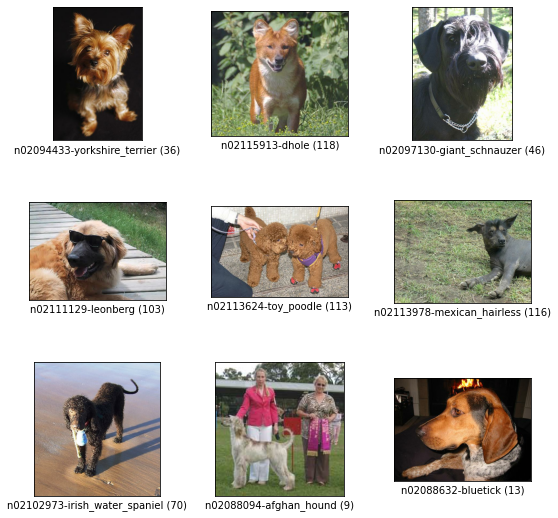

In [ ]:
ex_train = tfds.show_examples(ds_train, ds_info)

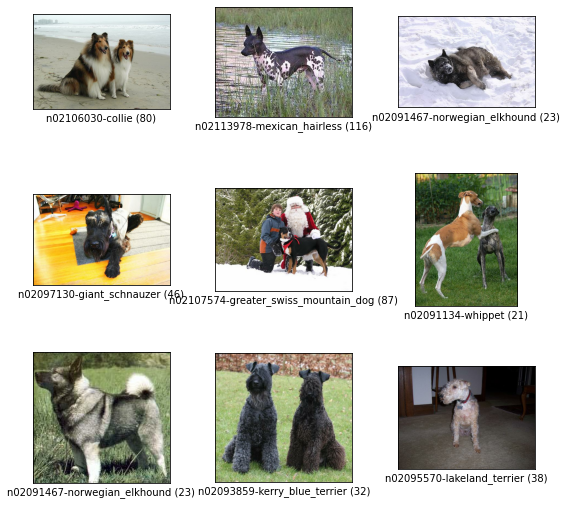

In [ ]:
ex_test = tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


<br>


-----
### CAM 구현하기

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 180s 215ms/step - loss: 2.2155 - accuracy: 0.4467 - val_loss: 3.4140 - val_accuracy: 0.2056
Epoch 2/15
750/750 [==============================] - 161s 214ms/step - loss: 0.6859 - accuracy: 0.8156 - val_loss: 1.0720 - val_accuracy: 0.6776
Epoch 3/15
750/750 [==============================] - 160s 214ms/step - loss: 0.1817 - accuracy: 0.9657 - val_loss: 0.9204 - val_accuracy: 0.7368
Epoch 4/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0472 - accuracy: 0.9978 - val_loss: 0.8956 - val_accuracy: 0.7396
Epoch 5/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.9027 - val_accuracy: 0.7424
Epoch 6/15
750/750 [==============================] - 160s 213ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.9296 - val_accuracy: 0.7389
Epoch 7/15
750/750 [==============================] - 160s 214ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9448 - val_accura

In [ ]:
# 가중치 저장하기
cam_model_path = 'cam_model1.h5'
cam_model.save(cam_model_path)

In [ ]:
# Class Activation Map
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


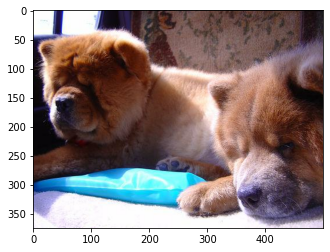

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
cam_model_path = 'cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

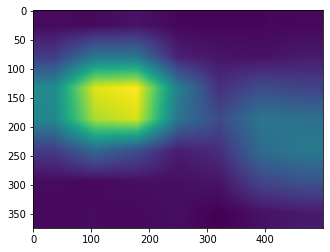

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

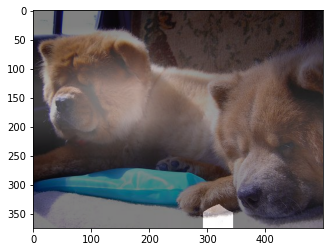

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<br>


-----
### Grad-CAM 구현하기

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [ ]:
def visualize_result(blockname):
  grad_cam_image = generate_grad_cam(cam_model, blockname, item)

  origin_image = item['image'].astype(np.uint8)
  grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
  blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

  plt.figure(figsize=(15,30))
  plt.subplot(1,2,1)
  plt.title('CAM image')
  plt.imshow(grad_cam_image)

  plt.subplot(1,2,2)
  plt.title('visualize CAM on image')
  plt.imshow(blended_image)
  plt.show()

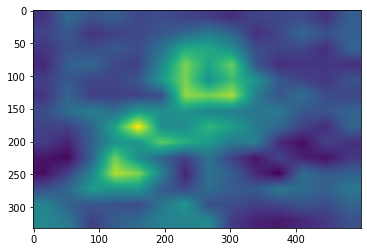

In [ ]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

<br>


-----
### 바운딩 박스 구하기

67


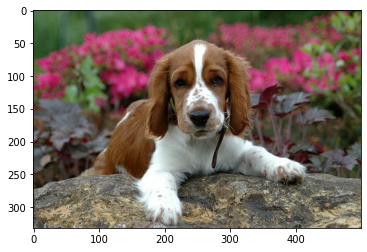

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

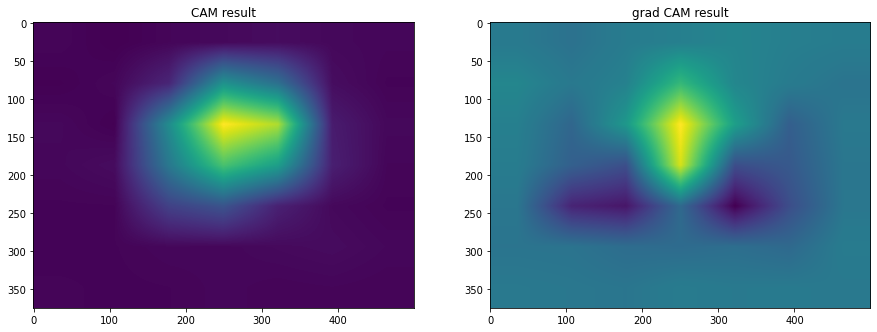

In [ ]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(cam_image)
plt.title('CAM result')

plt.subplot(1,2,2)
plt.imshow(grad_cam_image)
plt.title('grad CAM result')

plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect1 = get_bbox(cam_image)
rect2 = get_bbox(grad_cam_image)
rect1

array([[115, 336],
       [ 51,  99],
       [397,   4],
       [462, 242]])

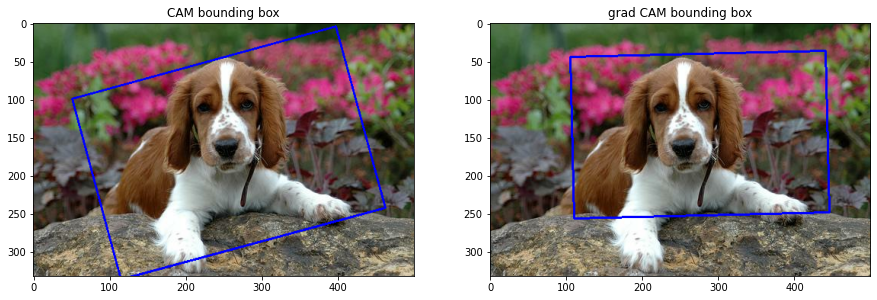

In [ ]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.title('CAM bounding box')

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title('grad CAM bounding box')
plt.show()

<br>


-----
### IoU 구하기

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [ ]:
pred_bbox1 = rect_to_minmax(rect1, item['image'])
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox1

[0.08266666666666667, 0.224, 0.76, 0.84]

In [ ]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [ ]:
def get_iou(boxA, boxB):  # iou 계산
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
# CAM bounding box IoU
get_iou(pred_bbox1, item['objects']['bbox'][0])

0.6129092826939376

In [ ]:
# grad CAM bounding box IoU
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.7766520298823889

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

cam의 기본적인 구조에서 기울기를 이용하는 과정을 grad-cam이라는 것 까지는 알겠는데, 이게 구체적으로 어떻게 진행되는지 아직 불분명하다. 오히려 Global Average Pooling에서의 과정이 훨씬 와닿았는데, 이 과정에서 좀 더 안쪽의 기울기를 적극적으로 가용한 게 grad-cam이 왜 더 효율이 좋은지 다시 생각해보게 만들었다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

단순히 모델의 과정 자체를 시각화한다는 자체도 신기했는데, 히트맵같은 구조를 활용해서 모델이 어딜 이용해서 라벨링을 구분하는지를 직관적으로 볼 수 있다는 데서 얼마나 많은 사람들이 딥러닝의 과정을 보기 위해 노력했는지가 느껴졌다. 하지만 이 과정 조차도 사람이 이해할 수 있는 구조로 바꾼 것 뿐이라는 생각을 왠지 지울 수 없었다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?                                 | ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.<br>                                                        |
| **2** | 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? | CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.                               |
| **3** | 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?                                    | CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다. |

grad-CAM의 성능이 미묘하게 더 좋다는 점에서 제대로 돌아간 게 맞는지까지 확인할 수 있었는데, IoU를 이용해서 결과를 도출하는 과정이 좀 막혔었다. 오히려 cam의 성능이 좋았던 경우도 있었는데 사진을 바꾸니까 제대로 돌아왔던게 데이터 때문인가 고민하게 만들었다. 어쨌거나 깃허브의 운총 덕분에 어렵지 않게 마무리 지을 수 있었다.


<br>

#### ▶️ 자기 다짐

원활하게 돌아가는 코드를 도움없이 짠다는건 쉽지 않다. 똑같은 코드를 제대로 된 타이밍에 온전히 생각하면서 오류없이 구현할 수 있을까를 묻는다면 아직도 자신이 없다........

<br>

## ✔️Reference(참고자료)
---
* https://github.com/Ssuwani/aiffel/blob/6c5b849fb55407e8fb08706c6fb619c12827f9ed/goingdeeper/G6/cam-vs-gradcam.ipynb
* https://github.com/software1398/aiffel/blob/09cd8db8e9914fc0bf4991871f860b077dbdde13/CV/CV10%20-%20Class%20Activation%20Map.ipynb
* https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/
* https://wikidocs.net/135874
* https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp
* https://jsideas.net/grad_cam/